<a href="https://colab.research.google.com/github/hammaad2002/RHM_FYP/blob/main/Transformer_on_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!git clone https://github.com/alphaameer007/RHM_FYP

In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random
import math
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df=pd.read_csv('/content/RHM_FYP/TurkeyWindFarm.csv')
df

,time,LV ActivePower (kW),Wind Speed (m/s),wind energy,Wind Direction (°)
0,1/1/2018 0:00,380.047791,5.311336,416.328908,259.994904
1,1/1/2018 0:10,453.769196,5.672167,519.917511,268.641113
2,1/1/2018 0:20,306.376587,5.216037,390.900016,272.564789
3,1/1/2018 0:30,419.645904,5.659674,516.127569,271.258087
4,1/1/2018 0:40,380.650696,5.577941,491.702972,265.674286
...,...,...,...,...,...
52555,12/31/2018 23:10,2963.980957,11.404030,3397.190793,80.502724
52556,12/31/2018 23:20,1684.353027,7.332648,1173.055771,84.062599
52557,12/31/2018 23:30,2201.106934,8.435358,1788.284755,84.742500
52558,12/31/2018 23:40,2515.694092,9.421366,2418.382503,84.297913


In [4]:
df.drop('time', inplace=True, axis=1)
df

,LV ActivePower (kW),Wind Speed (m/s),wind energy,Wind Direction (°)
0,380.047791,5.311336,416.328908,259.994904
1,453.769196,5.672167,519.917511,268.641113
2,306.376587,5.216037,390.900016,272.564789
3,419.645904,5.659674,516.127569,271.258087
4,380.650696,5.577941,491.702972,265.674286
...,...,...,...,...
52555,2963.980957,11.404030,3397.190793,80.502724
52556,1684.353027,7.332648,1173.055771,84.062599
52557,2201.106934,8.435358,1788.284755,84.742500
52558,2515.694092,9.421366,2418.382503,84.297913


In [5]:
max_values = df.max()              #normalizing data in between range [0,1]
df = df.div(max_values) 
df

,LV ActivePower (kW),Wind Speed (m/s),wind energy,Wind Direction (°)
0,0.105022,0.210717,0.115647,0.722213
1,0.125394,0.225032,0.144422,0.746230
2,0.084664,0.206936,0.108583,0.757129
3,0.115965,0.224537,0.143369,0.753500
4,0.105189,0.221294,0.136584,0.737989
...,...,...,...,...
52555,0.819066,0.452433,0.943664,0.223620
52556,0.465454,0.290909,0.325849,0.233509
52557,0.608253,0.334657,0.496746,0.235397
52558,0.695186,0.373775,0.671773,0.234162


In [6]:
#switching columns to make LV activePower (kW) last column so that it will be easy
# to prepare training and test datasets
cols = df.columns.tolist()
cols[0], cols[3] = cols[3], cols[0]
df = df[cols]
df

,Wind Direction (°),Wind Speed (m/s),wind energy,LV ActivePower (kW)
0,0.722213,0.210717,0.115647,0.105022
1,0.746230,0.225032,0.144422,0.125394
2,0.757129,0.206936,0.108583,0.084664
3,0.753500,0.224537,0.143369,0.115965
4,0.737989,0.221294,0.136584,0.105189
...,...,...,...,...
52555,0.223620,0.452433,0.943664,0.819066
52556,0.233509,0.290909,0.325849,0.465454
52557,0.235397,0.334657,0.496746,0.608253
52558,0.234162,0.373775,0.671773,0.695186


In [7]:
target=df['LV ActivePower (kW)']
target.shape

(52560,)

In [8]:
# Calculate the number of readings per day
readings_per_day = 144

#n = number of day
n = 3

# Calculate the sequence length (n days in readings)
sequence_length = readings_per_day * n

# Set the lookback window to be the same as the sequence length
lookback_window = sequence_length

# Convert the data to a NumPy array
df = df.values

x, y = [], []
for i in range(lookback_window, len(df)):
    x.append(df[i - lookback_window:i, :])
    y.append(df[i, -1])
x = np.array(x)
y = np.array(y)
print(x.shape)
print(y.shape)

(52128, 432, 4)
(52128,)


In [9]:
# Calculate the number of test samples (last 3 days of the year)
num_test_samples = readings_per_day * 3

# Split the data into training and test sets
x_train = x[:-num_test_samples]
y_train = y[:-num_test_samples]
x_test = x[-num_test_samples:]
y_test = y[-num_test_samples:]

In [10]:
print(x_train.shape)
print(y_train.shape)

(51696, 432, 4)
(51696,)


In [11]:
print(x_test.shape)
print(y_test.shape)

(432, 432, 4)
(432,)


In [13]:
class PositionalEncoding(nn.Module):
    def __init__(self, embedding_size, dropout_p, max_len):
        super().__init__()
        self.dropout = nn.Dropout(dropout_p)
        position = torch.arange(max_len).unsqueeze(1)                                                           #col vector    #add another dimension from (max_len) -> (maxlen,1)
        div_term = torch.exp(torch.arange(0, embedding_size, 2).float() * (-math.log(10000.0)) / embedding_size)#row vector    #1 / 10000^(2i/embedding_size) -> div_term
        sinusoid = torch.zeros(max_len, embedding_size)                                                                        # (max_len,embedding size)
        sinusoid[:, 0::2] = torch.sin(position * div_term)                                                      #col * row     # (time_step , even embedding added with sine  * div_term)  
        sinusoid[:, 1::2] = torch.cos(position * div_term)                                                                     # (time_step , odd embedding added with cosine * div_term) 
        self.register_buffer('pos_encoding', sinusoid.unsqueeze(0))                                                            #creating register buffer in pytorch graph
    def forward(self, x):
        x = x + self.pos_encoding[:, :x.size(1)]                                                                               #addition of positional encoding with our embedded input
        return self.dropout(x) 

In [14]:
class PositionalEncoding(nn.Module):
    def __init__(self, embedding_size, dropout_p, max_len):
        super().__init__()
        self.dropout = nn.Dropout(dropout_p)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embedding_size, 2).float() * (-math.log(10000.0)) / embedding_size)
        sinusoid = torch.zeros(max_len, embedding_size)
        sinusoid[:, 0::2] = torch.sin(position * div_term)
        sinusoid[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pos_encoding', sinusoid.unsqueeze(0))

    def forward(self, x):
        pos_encoding = self.pos_encoding[:, :x.size(1), :]  # Resize pos_encoding to match the input size of x
        x = x + pos_encoding
        return self.dropout(x)

In [20]:
class Transformer(nn.Module):
    def __init__(self, input_size, dim_model, num_heads, num_encoder_layers, num_decoder_layers, dropout_p, out_size):
        super().__init__()
        self.model_type = "Transformer"
        self.dim_model = dim_model
        self.positional_encoder = PositionalEncoding(embedding_size=dim_model, dropout_p=dropout_p, max_len=432)
        self.embedding = nn.Linear(input_size, dim_model)
        self.transformer = nn.Transformer(d_model=dim_model, nhead=num_heads, num_encoder_layers=num_encoder_layers, num_decoder_layers=num_decoder_layers, dropout=dropout_p)
        self.out = nn.Linear(dim_model, out_size)

    def get_tgt_mask(self, tgt_len):
        # Function to create a square attention mask for the decoder
        mask = torch.triu(torch.ones(tgt_len, tgt_len)) == 1
        mask = mask.float().masked_fill(mask == 0, float("-inf")).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, x):
        device = "cuda" if torch.cuda.is_available() else "cpu"
        # x shape: (batch_size, sequence_length, num_features)
        x = self.embedding(x) * math.sqrt(self.dim_model)
        x = self.positional_encoder(x)
        x = x.permute(1, 0, 2)  # (sequence_length, batch_size, dim_model)
        transformer_out = self.transformer(x, x, tgt_mask=self.get_tgt_mask(x.size(0)).to(device))
        out = self.out(transformer_out[-1])
        return out.squeeze()

In [21]:
# Define model parameters
seq_length = 432
input_size = 4
dim_model = 16
num_heads = 8
num_encoder_layers = 3
num_decoder_layers = 3
dropout_p = 0.2
out_size = 1
device = "cuda" if torch.cuda.is_available() else "cpu"
# Initialize the model
model = Transformer(
    input_size=input_size,
    dim_model=dim_model,
    num_heads=num_heads,
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    dropout_p=dropout_p,
    out_size=out_size,
).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Convert data to tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)

# Train the model
num_epochs = 1
batch_size = 32
for epoch in range(num_epochs):
    running_loss = 0.0
    for i in range(0, len(x_train), batch_size):
        # Get batch of inputs and targets
        batch_x = x_train_tensor[i:i+batch_size]
        batch_y = y_train_tensor[i:i+batch_size]
        
        # Reshape input tensor
        batch_x = batch_x.view(-1, seq_length, input_size)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_x)
        loss = criterion(outputs.view(-1), batch_y)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / (len(x_train) / batch_size)
    print(f"Epoch {epoch+1} loss: {epoch_loss:.6f}")


Epoch 1 loss: 0.082445


In [23]:
# Convert test data to tensor
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)

# Forward pass on test input tensor
with torch.no_grad():
    outputs = model(x_test_tensor)

# Reshape output tensor to (432,) shape
outputs = outputs.view(-1)

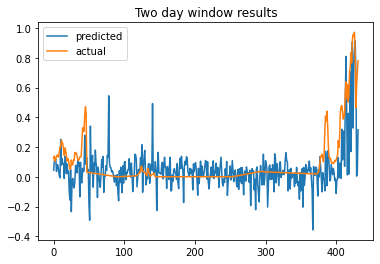

In [29]:
plt.plot(outputs.cpu().detach())
plt.plot(y_test) #denormalizing original data back
plt.title('Two day window results')
plt.legend(['predicted', 'actual'])
plt.show()